In [61]:
# Packages
import numpy as np
from scipy import stats
import pandas as pd
import matplotlib.pyplot as plt
import missingno as msno
import seaborn as sns
from datetime import date,datetime
import warnings
warnings.filterwarnings('ignore') 

In [5]:
# Plot settings
sns.set_context('notebook') 
sns.set_style('ticks') 
colours = ['#1F77B4', '#FF7F0E', '#2CA02C', '#DB2728', '#9467BD', '#8C564B', '#E377C2','#7F7F7F', '#BCBD22', '#17BECF']
crayon = ['#4E79A7','#F28E2C','#E15759','#76B7B2','#59A14F', '#EDC949','#AF7AA1','#FF9DA7','#9C755F','#BAB0AB']
sns.set_palette(colours)
%matplotlib inline
plt.rcParams['figure.figsize'] = (9, 6)

In [90]:
# Model selection and evaluation tools
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV, train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, roc_auc_score
from sklearn.metrics import mean_squared_error, r2_score,  mean_absolute_error
from sklearn.metrics import precision_score, average_precision_score, log_loss
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor 
from sklearn.linear_model import LinearRegression, LassoCV, RidgeCV, ElasticNetCV
from sklearn.tree import DecisionTreeRegressor
import xgboost as xgb
from mlxtend.regressor import StackingCVRegressor

# Data processing
from sklearn.preprocessing import StandardScaler

In [79]:
import sys
sys.path.insert(0, '/Users/yg/insight/github/data_challenges')
from statlearning import plot_coefficients

## Video game sales analysis

Business objectives:
1. What are some major differences between the North American, European, and Japanese video game markets?

2. What video game genres are trending in each market? 

3. What features about a video game are most indicative of its success?


## Data wrangling

In [7]:
df = pd.read_csv('vgsales.csv')
print('Number of rows:',len(df))
df.head()

Number of rows: 16598


,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


In [8]:
df.dtypes

Rank              int64
Name             object
Platform         object
Year            float64
Genre            object
Publisher        object
NA_Sales        float64
EU_Sales        float64
JP_Sales        float64
Other_Sales     float64
Global_Sales    float64
dtype: object

In [9]:
df.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006.0,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985.0,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008.0,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009.0,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


In [10]:
df['Platform'].value_counts(normalize=True)

DS      0.130317
PS2     0.130196
PS3     0.080070
Wii     0.079829
X360    0.076214
PSP     0.073081
PS      0.072057
PC      0.057838
XB      0.049645
GBA     0.049524
GC      0.033498
3DS     0.030666
PSV     0.024883
PS4     0.020243
N64     0.019219
SNES    0.014399
XOne    0.012833
SAT     0.010423
WiiU    0.008615
2600    0.008013
GB      0.005904
NES     0.005904
DC      0.003133
GEN     0.001627
NG      0.000723
WS      0.000361
SCD     0.000361
3DO     0.000181
TG16    0.000120
PCFX    0.000060
GG      0.000060
Name: Platform, dtype: float64

In [11]:
df['Genre'].value_counts(normalize=True)

Action          0.199783
Sports          0.141342
Misc            0.104772
Role-Playing    0.089649
Shooter         0.078925
Adventure       0.077479
Racing          0.075250
Platform        0.053380
Simulation      0.052235
Fighting        0.051090
Strategy        0.041029
Puzzle          0.035064
Name: Genre, dtype: float64

In [12]:
df['Name'].value_counts(normalize=False)

Need for Speed: Most Wanted                                12
FIFA 14                                                     9
LEGO Marvel Super Heroes                                    9
Ratatouille                                                 9
Madden NFL 07                                               9
Terraria                                                    8
LEGO Harry Potter: Years 5-7                                8
Monopoly                                                    8
FIFA 15                                                     8
The LEGO Movie Videogame                                    8
FIFA Soccer 13                                              8
Madden NFL 08                                               8
LEGO Jurassic World                                         8
Angry Birds Star Wars                                       8
LEGO The Hobbit                                             8
LEGO Star Wars II: The Original Trilogy                     8
Cars    

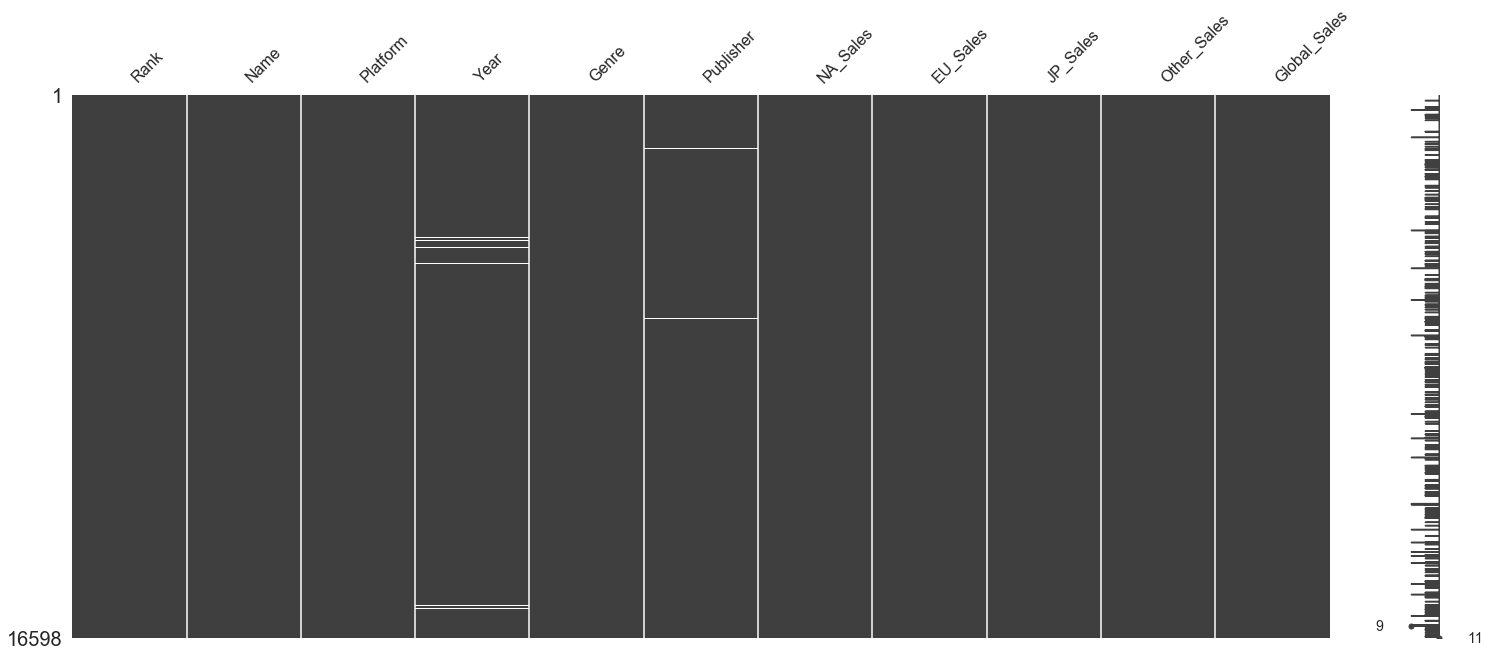

In [13]:
msno.matrix(df);

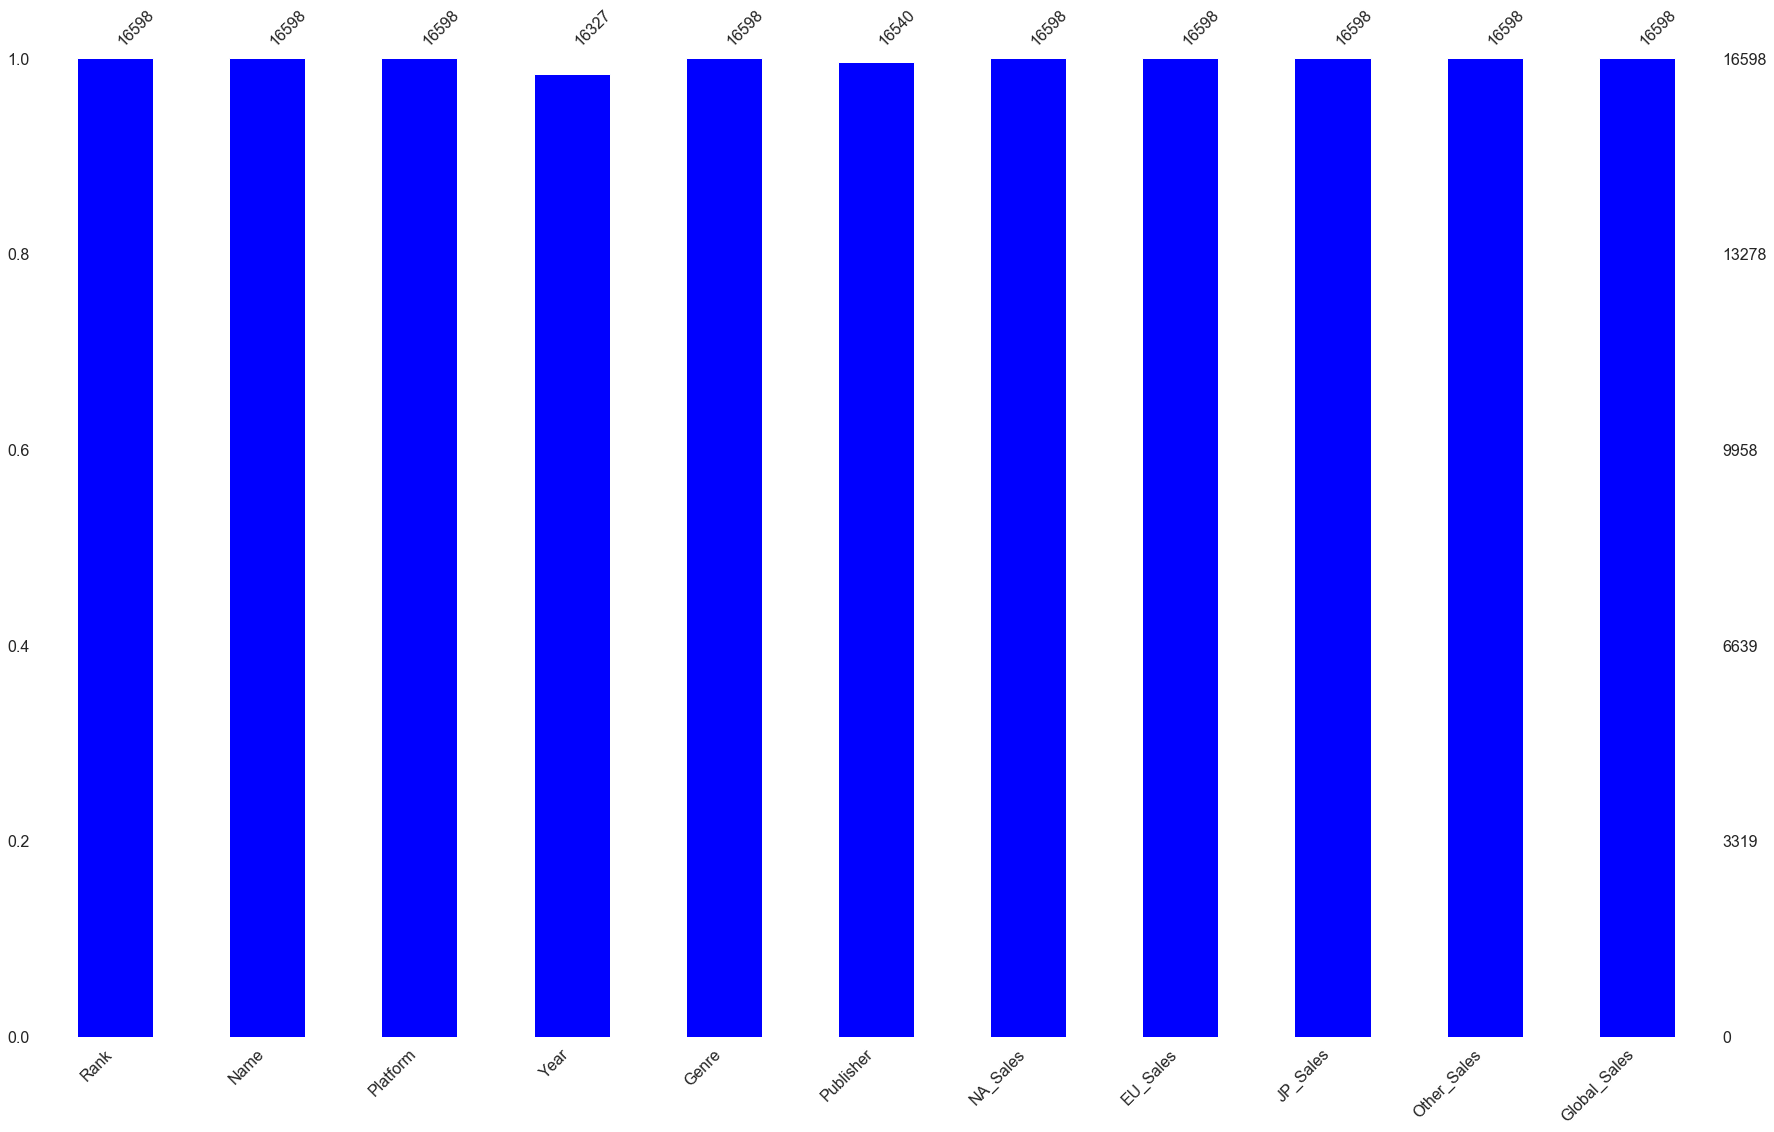

In [14]:
msno.bar(df, color="blue", figsize=(30,18));

Most of the data is not missing so we can drop the nan values.

In [15]:
cleaned_df = df.dropna()

In [16]:
cleaned_df['Year'] = cleaned_df['Year'].fillna(0).astype(np.int64)
cleaned_df = cleaned_df.drop(cleaned_df[cleaned_df['Year'] >= 2018].index)
cleaned_df['Year'] = pd.to_datetime(cleaned_df['Year'], format='%Y')

In [17]:
cleaned_df.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006-01-01,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985-01-01,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008-01-01,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009-01-01,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996-01-01,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


In [18]:
cleaned_df.dtypes

Rank                     int64
Name                    object
Platform                object
Year            datetime64[ns]
Genre                   object
Publisher               object
NA_Sales               float64
EU_Sales               float64
JP_Sales               float64
Other_Sales            float64
Global_Sales           float64
dtype: object

In [19]:
cleaned_df.describe()

,Rank,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
count,16290.000000,16290.000000,16290.000000,16290.000000,16290.000000,16290.000000
mean,8290.333333,0.265646,0.147740,0.078838,0.048428,0.540926
std,4792.766754,0.822457,0.509317,0.311888,0.190089,1.567391
min,1.000000,0.000000,0.000000,0.000000,0.000000,0.010000
25%,4132.250000,0.000000,0.000000,0.000000,0.000000,0.060000
50%,8292.500000,0.080000,0.020000,0.000000,0.010000,0.170000
75%,12439.750000,0.240000,0.110000,0.040000,0.040000,0.480000
max,16600.000000,41.490000,29.020000,10.220000,10.570000,82.740000


Now the data looks ok.

In [20]:
print('Min rank={}, max rank={}'.format(min(cleaned_df['Rank']),max(cleaned_df['Rank'])))

Min rank=1, max rank=16600


# What are some major differences between the North American, European, and Japanese video game markets?

In [21]:
cleaned_df_long = pd.melt(cleaned_df, id_vars=['Year','Genre','Platform','Publisher'],
                            value_vars=['NA_Sales', 'EU_Sales','JP_Sales'],
                            var_name = 'Region', value_name = 'Sales')
cleaned_df_long.head()

,Year,Genre,Platform,Publisher,Region,Sales
0,2006-01-01,Sports,Wii,Nintendo,NA_Sales,41.49
1,1985-01-01,Platform,NES,Nintendo,NA_Sales,29.08
2,2008-01-01,Racing,Wii,Nintendo,NA_Sales,15.85
3,2009-01-01,Sports,Wii,Nintendo,NA_Sales,15.75
4,1996-01-01,Role-Playing,GB,Nintendo,NA_Sales,11.27


## Breakdown per platform and publisher

In [22]:
platform_grouped = cleaned_df_long.groupby(['Platform']).mean()
platform_grouped.reset_index(inplace=True)
platform_grouped.head()

,Platform,Sales
0,2600,0.246092
1,3DO,0.011111
2,3DS,0.156059
3,DC,0.100513
4,DS,0.118518


In [23]:
platform_order = platform_grouped.sort_values(by='Sales', ascending=False)['Platform'].values
platform_order[:10]

array(['GB', 'NES', 'GEN', 'SNES', '2600', 'X360', 'PS4', 'N64', 'Wii',
       'PS3'], dtype=object)

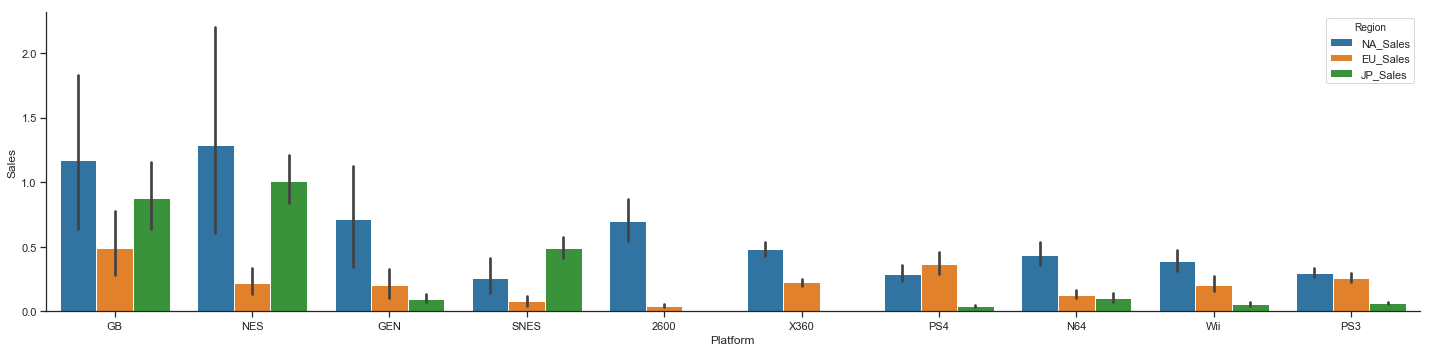

In [24]:
plt.figure(figsize=(20,5))
sns.barplot(data=cleaned_df_long, x='Platform',y='Sales', hue='Region', order=platform_order[:10]);
sns.despine()
plt.tight_layout()

Cross regions most profitable platforms are:'GB', 'NES', 'GEN', 'SNES', '2600', 'X360', 'PS4', 'N64', 'Wii', 'PS3'.
Regional differences exist.

In [25]:
publisher_grouped = cleaned_df_long.groupby(['Publisher']).mean()
publisher_grouped.reset_index(inplace=True)
publisher_grouped.head()

,Publisher,Sales
0,10TACLE Studios,0.012222
1,1C Company,0.008889
2,20th Century Fox Video Games,0.128000
3,2D Boy,0.010000
4,3DO,0.088148


In [26]:
publisher_order = publisher_grouped.sort_values(by='Sales', ascending=False)['Publisher'].values
publisher_order[:10]

array(['Palcom', 'Red Orb', 'Nintendo', 'Arena Entertainment',
       'UEP Systems', 'RedOctane', 'Westwood Studios', 'Valve',
       'Sony Computer Entertainment Europe', 'Hello Games'], dtype=object)

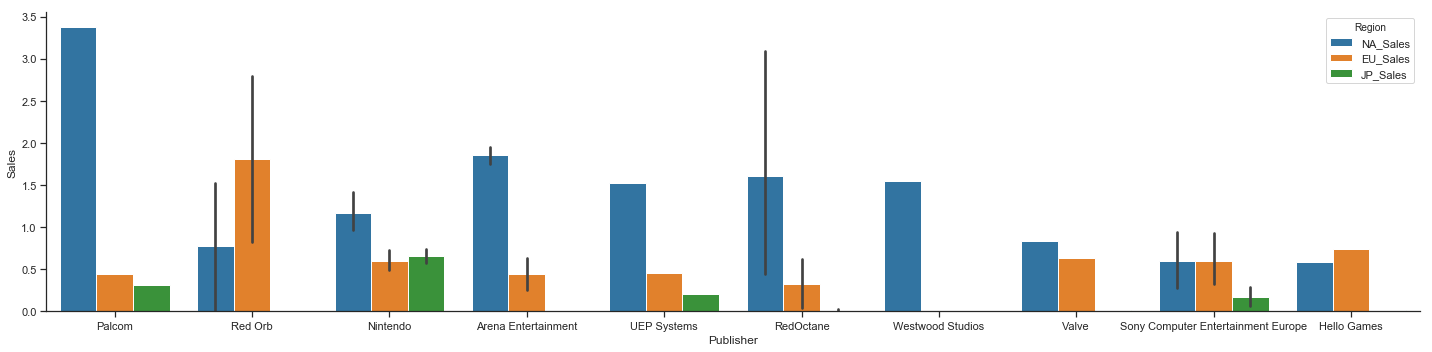

In [27]:
plt.figure(figsize=(20,5))
sns.barplot(data=cleaned_df_long, x='Publisher',y='Sales', hue='Region', order=publisher_order[:10]);
sns.despine()
plt.tight_layout()

* For NA, top publishers:
    + Palcom
    + Arena Entertainment
    + RedOctane
    + UEP Systems
    + Westwood Studios

* For Europe:
    + Red Orb
    + Hello Games
    + Valve
    + Nintendo
    
* For Japan:
    + Nintendo
    + Palcom
    + UEP System
    + Sony Computer Entertainment Europe
    
    

## Total sales over time

In [28]:
year_region_df = cleaned_df_long.groupby(['Year','Region'], level=None).sum()
year_region_df.reset_index(inplace=True)
year_region_df.set_index('Year', inplace=True)
year_region_df.head()

,Region,Sales
Year,,
1980-01-01,EU_Sales,0.67
1980-01-01,JP_Sales,0.00
1980-01-01,NA_Sales,10.59
1981-01-01,EU_Sales,1.96
1981-01-01,JP_Sales,0.00


In [29]:
NA_Sales = year_region_df[year_region_df.Region=='NA_Sales']['Sales']
EU_Sales = year_region_df[year_region_df.Region=='EU_Sales']['Sales']
JP_sales = year_region_df[year_region_df.Region=='JP_Sales']['Sales']

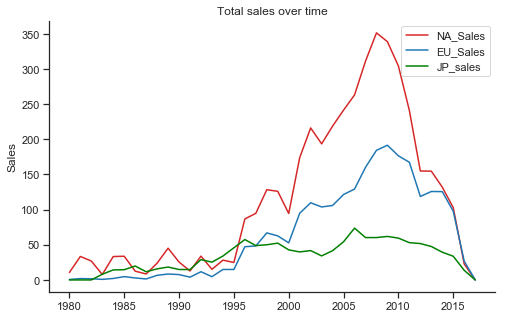

In [30]:
sns.set_style('ticks')
red='#D62728'
blue='#1F77B4'
fig, ax = plt.subplots(figsize=(8,5))
NA_Sales.plot(color=red)
EU_Sales.plot(color=blue)
JP_sales.plot(color='g')
ax.set_xlabel('')
ax.set_ylabel('Sales')
ax.legend(['NA_Sales','EU_Sales','JP_sales'])
ax.set_title('Total sales over time')
ax.set_xticks([], minor=True) # I prefer to remove the minor ticks for a cleaner plot
sns.despine()
plt.show()

Sales peaked in 2010 to decline sharply after.

## Trends in market shares

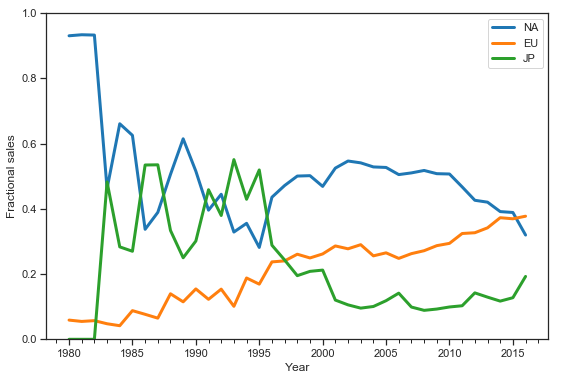

In [31]:
# Plot fractional sales grouping by year
value_to_check=datetime(2017, 1, 1)
filter_mask = cleaned_df['Year'] < value_to_check
filtered_df = cleaned_df[filter_mask]
year_pool = filtered_df.groupby(['Year']).mean()
year_pool['NA_div_GS'] = year_pool['NA_Sales']/year_pool['Global_Sales']
year_pool['JP_div_GS'] = year_pool['JP_Sales']/year_pool['Global_Sales']
year_pool['EU_div_GS'] = year_pool['EU_Sales']/year_pool['Global_Sales']
year_pool[['NA_div_GS', 'EU_div_GS', 'JP_div_GS']].plot(linewidth=3)
plt.ylabel('Fractional sales')
plt.legend(['NA', 'EU', 'JP'])
axes = plt.gca()
axes.set_ylim([0,1]);

More recently, NA sales are in decline, EU and JP sales are on the rise.

# What video game genres are trending in each market?

## Trending video game genres in each market

In [32]:
def plot_topn_cat(df, category, top_n, market):
    market_genre=df.groupby(by=['Year',category])[market].sum().unstack().fillna(value=0)
    market_topn = pd.DataFrame({col: market_genre.T[col].nlargest(top_n).index.tolist() 
                  for  col in market_genre.T}).T

    for ix in market_genre.index:
        col_list = [col for col in market_genre.columns ]
        col_list_top = [col for col in market_topn.loc[ix]]
        col_list_ntop = [col for col in col_list if col not in col_list_top]
        market_genre.loc[ix, col_list_ntop] =0
    #market_genre.plot(kind='bar', stacked=True, figsize=(10,10), colormap='Paired', title=market
    return market_genre

def plot_market_genre(market_genre, market, stacked=True):
    ts = market_genre.index.tolist() 

    if stacked:
        ax = market_genre.plot(kind='bar', stacked=True, figsize=(10,10), colormap='Paired')
    else:
         ax = market_genre.plot(figsize=(10,10))
            
    ax.set_xlim(0, len(ts))

    indexes = np.arange(0, len(ts), 5) # we will place ticks every 18 months, starting with the first observation 
    ax.set_xticks(indexes)
    ax.set_xticklabels([market_genre.index[i].strftime('%b-%y') for i in indexes], rotation='-90')

    indexes = np.arange(9, len(ts), 5) # minor ticks
    ax.set_xticks(indexes, minor=True)

    ax.set_xlabel('Year')
    ax.set_ylabel('Sales')
    ax.set_title(market)

    sns.despine()
    plt.tight_layout()

    plt.show()

In [33]:
market = 'NA_Sales'
market_genre = plot_topn_cat(cleaned_df, 'Genre', 3, market)

In [34]:
market_genre.head()

Genre,Action,Adventure,Fighting,Misc,Platform,Puzzle,Racing,Role-Playing,Shooter,Simulation,Sports,Strategy
Year,,,,,,,,,,,,
1980-01-01,0.00,0.0,0.72,2.53,0.00,0.00,0.0,0.0,6.56,0.0,0.00,0.0
1981-01-01,13.86,0.0,0.00,0.00,6.47,0.00,0.0,0.0,9.37,0.0,0.00,0.0
1982-01-01,6.07,0.0,0.00,0.00,4.69,9.35,0.0,0.0,0.00,0.0,0.00,0.0
1983-01-01,2.67,0.0,0.00,0.00,2.80,0.00,0.0,0.0,0.00,0.0,0.73,0.0
1984-01-01,0.00,0.0,0.00,0.00,0.00,0.00,2.3,0.0,27.79,0.0,1.70,0.0


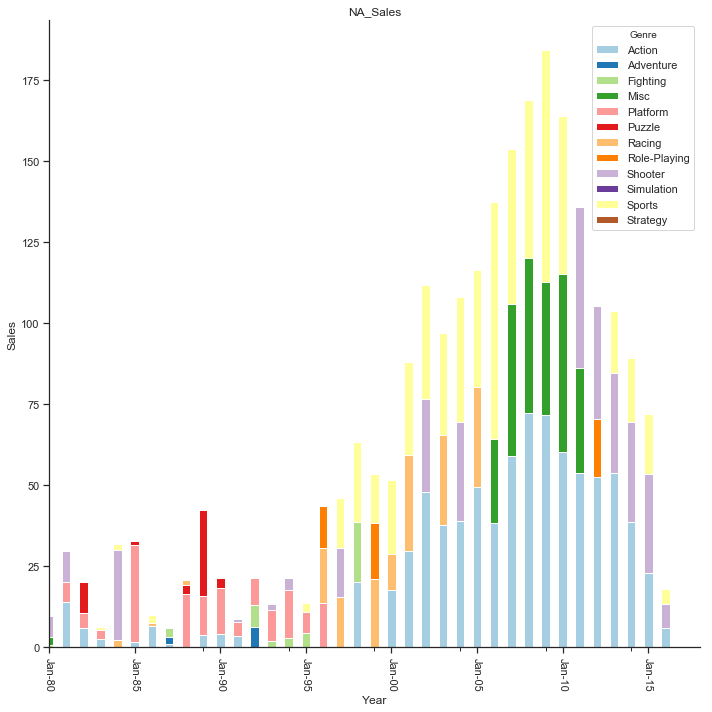

In [35]:
plot_market_genre(market_genre, market)

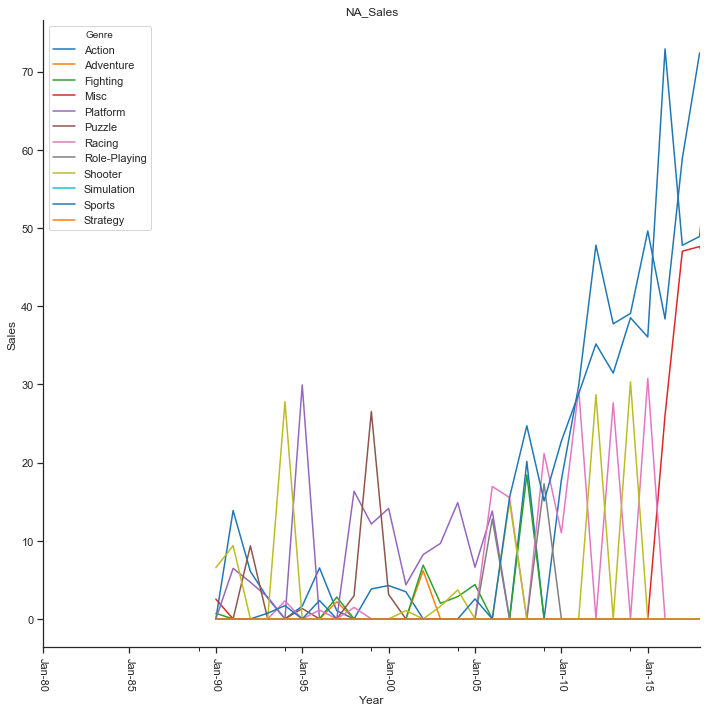

In [36]:
plot_market_genre(market_genre, market, stacked=False)

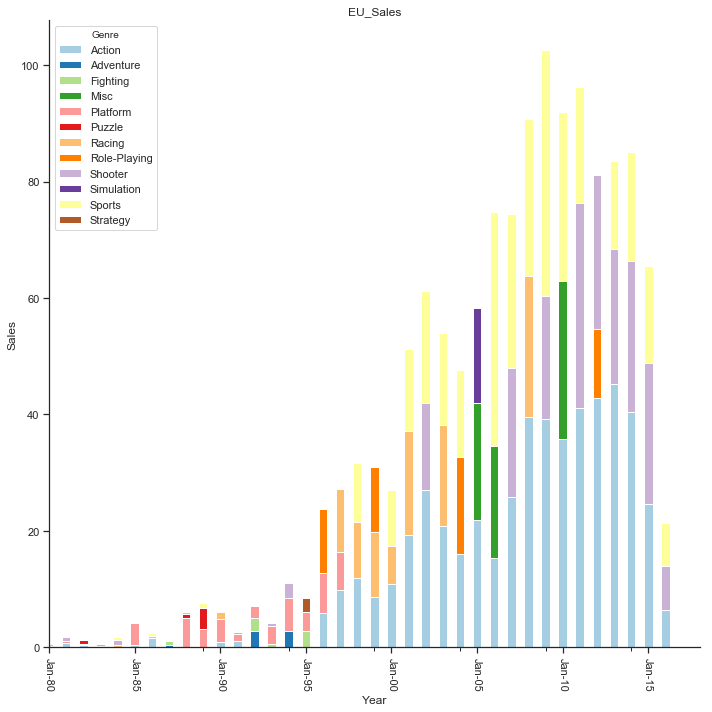

In [37]:
market = 'EU_Sales'
market_genre = plot_topn_cat(cleaned_df, 'Genre', 3, market)
plot_market_genre(market_genre, market)

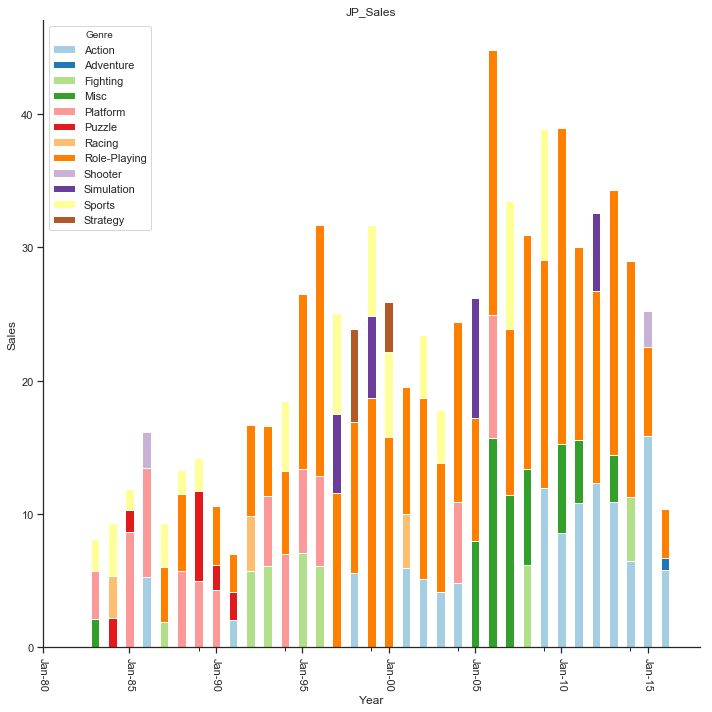

In [38]:
market = 'JP_Sales'
market_genre = plot_topn_cat(cleaned_df, 'Genre', 3, market)
plot_market_genre(market_genre, market)

In [39]:
# sns.set()
# def plot_year_genre(area):
#     na = cleaned_df.groupby(by=['Year','Genre'])[area].sum().unstack()
#     na = na.fillna(value=0)
#     value_to_check=datetime(1990, 1, 1)
#     na = na[na.index>=value_to_check]
#     na.plot(kind='bar', stacked=True,figsize=(12,8), title=str("By-genre sales amount (M$) in "+area[:2]))

# sns.set(font_scale=1.2)
# for genre in ['NA_Sales','EU_Sales','JP_Sales']:
#     plot_year_genre(genre)

In [40]:
grouped_df = cleaned_df_long.groupby(['Year','Genre','Region'], level=None).mean()
grouped_df.reset_index(inplace=True)
grouped_df.head()

,Year,Genre,Region,Sales
0,1980-01-01,Action,EU_Sales,0.02
1,1980-01-01,Action,JP_Sales,0.00
2,1980-01-01,Action,NA_Sales,0.32
3,1980-01-01,Fighting,EU_Sales,0.04
4,1980-01-01,Fighting,JP_Sales,0.00


In [41]:
value_to_check=datetime(2010, 1, 1)
filter_mask = grouped_df['Year'] >= value_to_check
grouped_recent_df = grouped_df[filter_mask]
grouped_recent_df.head()

,Year,Genre,Region,Sales
909,2010-01-01,Action,EU_Sales,0.158186
910,2010-01-01,Action,JP_Sales,0.037965
911,2010-01-01,Action,NA_Sales,0.266903
912,2010-01-01,Adventure,EU_Sales,0.034026
913,2010-01-01,Adventure,JP_Sales,0.023377


In [42]:
grouped_df.reset_index(inplace=True)
grouped_df.head()

,index,Year,Genre,Region,Sales
0,0,1980-01-01,Action,EU_Sales,0.02
1,1,1980-01-01,Action,JP_Sales,0.00
2,2,1980-01-01,Action,NA_Sales,0.32
3,3,1980-01-01,Fighting,EU_Sales,0.04
4,4,1980-01-01,Fighting,JP_Sales,0.00


In [43]:
grouped_recent_df.set_index('Year', inplace=True)
grouped_recent_df.head()

,Genre,Region,Sales
Year,,,
2010-01-01,Action,EU_Sales,0.158186
2010-01-01,Action,JP_Sales,0.037965
2010-01-01,Action,NA_Sales,0.266903
2010-01-01,Adventure,EU_Sales,0.034026
2010-01-01,Adventure,JP_Sales,0.023377


# What features about a video game are most indicative of its success?

Indicative features for the success of video games: good sales.
* The related features are:
    * Name: but it has 113k unique values.
    * Platform: 31 unique values.
    * Genre: 12 uniques values.
    * publisher: 576 unique values.

We will focus on "Platform" and "Genre".

In [49]:
class Rfr(object):
    """
    Random Forest Classifer Cross Validation Class
    Methods:
        fit: find best parameters and best model
        predict: scores
    """
    def __init__(self):
        self.param_grid = {
            'n_estimators': [10,20],
            'max_depth':[2, 4, 8],
            'min_samples_split':[4,8],
            'random_state':[42]
        }
        self.best_model = None
        self.best_params = {}
        num_test = 1
        for key, val in enumerate(self.param_grid):
            num_test *= len(val)
        print("\nStart to find the best parameters for random forest classifier using cross-validation.")
        print("Parameters combinations to test are:", self.param_grid)
        print("Total test to run: ", str(num_test), '\n')

    def fit(self, X, y):
        %%time
        # Create a based model
        print('Start training random forest classifier.')
        rfr = RandomForestRegressor()
        # Instantiate the grid search model
        grid_search = GridSearchCV(estimator = rfr, param_grid = self.param_grid,
                                  cv = 8, n_jobs = -1, verbose = 1)   # Using k-folds with cv=10
        grid_search.fit(X, y)
        self.best_params = grid_search.best_params_
        self.best_model = grid_search.best_estimator_
        print('Best parameters for random forest classifier is: ', str(self.best_params))

    def predict(self, X):
        return self.best_model.predict(X)

In [45]:
cleaned_df.head()

,Rank,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,1,Wii Sports,Wii,2006-01-01,Sports,Nintendo,41.49,29.02,3.77,8.46,82.74
1,2,Super Mario Bros.,NES,1985-01-01,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,3,Mario Kart Wii,Wii,2008-01-01,Racing,Nintendo,15.85,12.88,3.79,3.31,35.82
3,4,Wii Sports Resort,Wii,2009-01-01,Sports,Nintendo,15.75,11.01,3.28,2.96,33.00
4,5,Pokemon Red/Pokemon Blue,GB,1996-01-01,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


In [64]:
X = pd.get_dummies(cleaned_df.loc[:,['Publisher','Genre','Platform']])
y = cleaned_df['Global_Sales']
print(len(X))
print(len(y))

16290
16290


In [71]:
response='Global_Sales'
predictors=list(X.columns.values)

In [65]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30)

In [66]:
scaler = StandardScaler()
scaler.fit(X_train)
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [67]:
rfr = Rfr()
rfr.fit(X_train_scaled, y_train)


Start to find the best parameters for random forest classifier using cross-validation.
Parameters combinations to test are: {'n_estimators': [10, 20], 'max_depth': [2, 4, 8], 'min_samples_split': [4, 8], 'random_state': [42]}
Total test to run:  22032 

CPU times: user 3 µs, sys: 1 µs, total: 4 µs
Wall time: 7.87 µs
Start training random forest classifier.
Fitting 8 folds for each of 12 candidates, totalling 96 fits


[Parallel(n_jobs=-1)]: Done  26 tasks      | elapsed:   16.4s
[Parallel(n_jobs=-1)]: Done  96 out of  96 | elapsed:  1.5min finished


Best parameters for random forest classifier is:  {'max_depth': 2, 'min_samples_split': 4, 'n_estimators': 20, 'random_state': 42}


In [68]:
columns=['Test RMSE', 'Test R2', 'Test MAE']
rows=['RandomForestRegressor']
results=pd.DataFrame(0.0, columns=columns, index=rows) 
models=[rfr]

for i, model in enumerate(models):
    
    y_pred = model.predict(X_test_scaled)       
    results.iloc[i,0] = np.sqrt(mean_squared_error(y_test, y_pred))
    results.iloc[i,1] = r2_score(y_test, y_pred)
    results.iloc[i,2] = mean_absolute_error(y_test, y_pred)

results.round(3)

,Test RMSE,Test R2,Test MAE
RandomForestRegressor,1.227,0.018,0.548


## Linear Regression

In [74]:
ols = LinearRegression()
ols.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=1, normalize=False)

In [106]:
columns=['Test RMSE', 'Test R2', 'Test MAE']
rows=['OLS']
results=pd.DataFrame(0.0, columns=columns, index=rows) 
models=[ols]

for i, model in enumerate(models):
    
    y_pred = model.predict(X_test)       
    results.iloc[i,0] = np.sqrt(mean_squared_error(y_test, y_pred))
    results.iloc[i,1] = r2_score(y_test, y_pred)
    results.iloc[i,2] = mean_absolute_error(y_test, y_pred)

results.round(3)

,Test RMSE,Test R2,Test MAE
OLS,1.424799e+12,-1.324201e+24,1.335100e+11


## Regularised Linear Models

### Lasso

In [77]:
lasso = Pipeline((
    ('scaler', StandardScaler()),
    ('estimator', LassoCV(cv=5)),
))

lasso.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('estimator', LassoCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
    max_iter=1000, n_alphas=100, n_jobs=1, normalize=False, positive=False,
    precompute='auto', random_state=None, selection='cyclic', tol=0.0001,
    verbose=False))])

The lasso shrinks 88 coefficients to zero.

In [83]:
reg = lasso._final_estimator # the final estimator attribute refers to the pipeline
np.sum(reg.coef_==0.0)

336

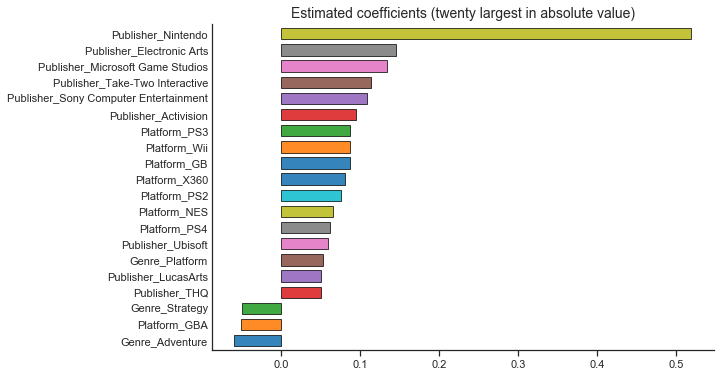

In [84]:
plot_coefficients(reg, predictors)
plt.show()

### Ridge Regression

In [82]:
alphas = list(np.logspace(-15, 15, 151, base=2))

ridge = Pipeline((
    ('scaler', StandardScaler()),
    ('estimator', RidgeCV(alphas=alphas, cv=5)),
))

ridge.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('estimator', RidgeCV(alphas=[3.0517578125e-05, 3.505549179068098e-05, 4.026818575356734e-05, 4.625599873383782e-05, 5.313418965430448e-05, 6.103515625e-05, 7.011098358136196e-05, 8.053637150713468e-05, 9.251199746767564e-0...cv=5, fit_intercept=True, gcv_mode=None, normalize=False, scoring=None,
    store_cv_values=False))])

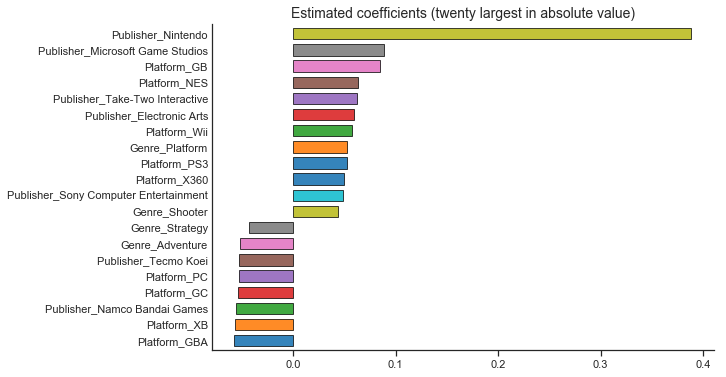

In [85]:
plot_coefficients(ridge._final_estimator, predictors)
plt.show()

### Elastic Net

In [86]:
enet = Pipeline((
    ('scaler', StandardScaler()),
    ('estimator', ElasticNetCV(l1_ratio=[0.01,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9, 0.99], cv=5)),
))

enet.fit(X_train, y_train)

Pipeline(memory=None,
     steps=[('scaler', StandardScaler(copy=True, with_mean=True, with_std=True)), ('estimator', ElasticNetCV(alphas=None, copy_X=True, cv=5, eps=0.001, fit_intercept=True,
       l1_ratio=[0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.99],
       max_iter=1000, n_alphas=100, n_jobs=1, normalize=False,
       positive=False, precompute='auto', random_state=None,
       selection='cyclic', tol=0.0001, verbose=0))])

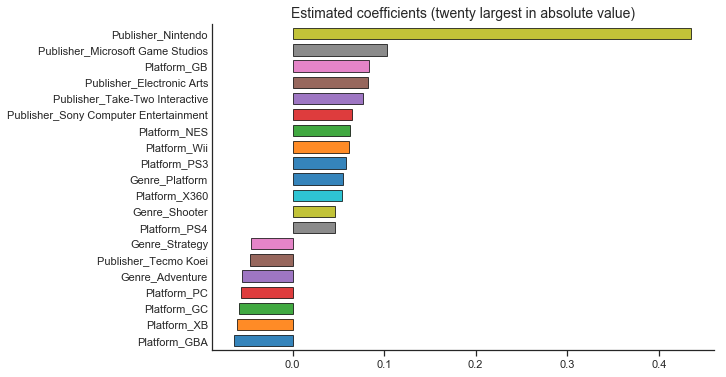

In [87]:
plot_coefficients(enet._final_estimator, predictors)
plt.show()

In [104]:
columns=['Test RMSE', 'Test R2', 'Test MAE']
rows=['Lasso', 'Ridge', 'Elastic Net']
models=[lasso, ridge, enet]
results=pd.DataFrame(0.0, columns=columns, index=rows) 

for i, model in enumerate(models):
    y_pred=np.exp(model.predict(X_test_scaled))   
    results.iloc[i,0] = np.sqrt(mean_squared_error(np.exp(y_test), y_pred))
    results.iloc[i,1] = r2_score(np.exp(y_test), y_pred)
    results.iloc[i,2] = mean_absolute_error(np.exp(y_test), y_pred)
results.round(3)

,Test RMSE,Test R2,Test MAE
Lasso,7.727257e+105,-3.259583e+180,1.105361e+104
Ridge,1.095816e+89,-6.555205e+146,1.567532e+87
Elastic Net,1.279013e+96,-8.930204e+160,1.829590e+94


### Regression Tree

In [91]:
%%time

model = DecisionTreeRegressor(min_samples_leaf=5)

tuning_parameters = {
    'min_samples_leaf': [1,5,10,20],
    'max_depth': np.arange(1,30),
}

tree = RandomizedSearchCV(model, tuning_parameters, n_iter=20, cv=5, return_train_score=False)
tree.fit(X_train, y_train)

print('Best parameters:', tree.best_params_)

Best parameters: {'min_samples_leaf': 20, 'max_depth': 24}
CPU times: user 31.9 s, sys: 500 ms, total: 32.4 s
Wall time: 14.4 s


### Random Forest Regression

In [92]:
%%time

model = RandomForestRegressor(n_estimators=100)

tuning_parameters = {
    'min_samples_leaf': [1,5, 10, 20, 50],
    'max_features': np.arange(1, X_train.shape[1], 5),
}

rf_search = RandomizedSearchCV(model, tuning_parameters, cv = 5, n_iter= 16, return_train_score=False, n_jobs=4,
                              random_state = 20)
rf_search.fit(X_train, y_train)

rf = rf_search.best_estimator_

print('Best parameters found by randomised search:', rf_search.best_params_, '\n')

Best parameters found by randomised search: {'min_samples_leaf': 5, 'max_features': 156} 

CPU times: user 7.9 s, sys: 161 ms, total: 8.06 s
Wall time: 3min 58s


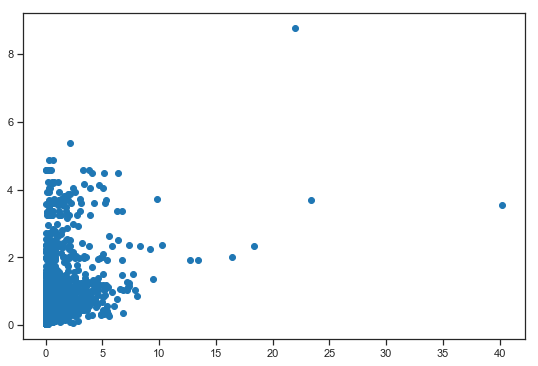

In [109]:
plt.scatter(y_test,rf.predict(X_test));

                                 features    weight
0               Publisher_10TACLE Studios  0.000000
1                    Publisher_1C Company  0.000000
2  Publisher_20th Century Fox Video Games  0.000000
3                        Publisher_2D Boy  0.000000
4                           Publisher_3DO  0.000039
               features    weight
359  Publisher_Nintendo  0.339903
614        Platform_Wii  0.072878
586        Genre_Sports  0.058894
593         Platform_GB  0.032886
576        Genre_Action  0.030456


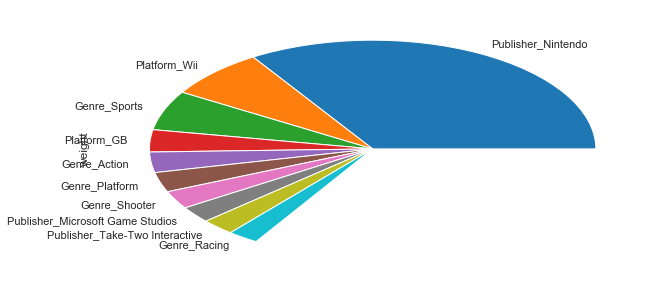

In [113]:
df_features = pd.DataFrame.from_dict({'features':list(X_train.columns),'weight':list(rf.feature_importances_)})
print(df_features.head())
df_features = df_features.sort_values(by='weight',ascending=False)
df_features.set_index('features')
print(df_features.head())
df_features_top10 = df_features.iloc[:10,:]
df_features_top10.plot.pie(y='weight',labels=df_features_top10.features, figsize=(10,5),legend=False);

### XGBoost

In [107]:
# %%time

# model = xgb.XGBRegressor()

# tuning_parameters = {
#     'learning_rate': [0.01, 0.05, 0.1],
#     'n_estimators' : [2000, 3000, 5000],
#     'max_depth' : [2, 3, 4],
#     'subsample' : [0.6, 0.8, 1.0],
# }

# # tuning_parameters = {
# #     'learning_rate': [0.01, 0.05, 0.1],
# #     'n_estimators' : [250, 500, 750, 1000, 1500, 2000, 3000, 5000],
# #     'max_depth' : [2, 3, 4],
# #     'subsample' : [0.6, 0.8, 1.0],
# # }

# gb_search = RandomizedSearchCV(model, tuning_parameters, n_iter = 16, cv = 5, return_train_score=False, n_jobs=4,
#                               random_state = 20)
# gb_search.fit(X_train, y_train)

# xbst = gb_search.best_estimator_


# print('Best parameters found by randomised search:', gb_search.best_params_, '\n')

### Model Stacking

In [ ]:
# %%time

# from mlxtend.regressor import StackingCVRegressor

# models = [ols, lasso, ridge, xbst]

# stack = StackingCVRegressor(models, meta_regressor = LinearRegression(), cv=10)
# stack.fit(X_train.values, y_train.ravel())